<a href="https://colab.research.google.com/github/kfrancis2017/csce556-labs/blob/main/CSCE556_Lab3_Pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCE 556 - Analysis of Experimental Data in Python

## Laboratory 3 - Data Wrangling with Pandas

The objective of this laboratory is to get acquainted with data wrangling using the Python package Pandas. We start by installing a few required packages and downloading data.

In [ ]:
# Install some required packages, if they are not already installed
!pip -q install pandas mne seaborn

# Install a package written for the course that includes a few function
# useful for this lab. Normally the following line should do the trick:
#!pip install git+https://github.com/christian-oreilly/csce590.git
# However, Colab sometimes has it quirks and for some reason this does not
# work. So we git-clone and install the package ourself
!git clone https://github.com/christian-oreilly/csce590.git
%cd csce590
!python setup.py install

## Data description

For this exercise, we will be using EEG data from the [LEMON dataset](https://fcon_1000.projects.nitrc.org/indi/retro/MPI_LEMON.html). By executing the previous cell, you now have access to the following files:
    
* data
    * sub-032344
        * sub-032344_EC.fdt
        * sub-032344_EC.set
        * sub-032344_EO.fdt
        * sub-032344_EO.set
    * sub-032432
        * sub-032432_EC.fdt
        * ...
    * ...

The six-digit ID following `"sub-"` is the subject identifier. For this laboratory, we will use only the data for subjects `"032344"`, `"032432"`, `"032480"`, and `"0322528"`. Every recording is described by two files, a header file with the extension `.set` and a second file with an extension `.fdt` containing the signals. These recordings are for *resting-state* data, i.e., recordings made while the participants are staying still, not doing any particular task. Two recordings are available for each participant, one with eyes closed (`EC`) and another with eyes open (`EO`).

## Reading data in

Using the `mne-python` package, these files can be read using `raw = mne.io.read_raw_eeglab(file_name)`. Use the `*.set` files as input to this function.

First, loop through these files, read them, and store them in a dictionary `raw[(exp_type, subject)]` where the variable `exp_type` takes as value either `"EO"` or `"EC"` and `subject` takes as values `"032344"`, `"032432"`, `"032480"`, or `"0322528"`. Note that the `Path` class from the `pathlib` library and its `glob` method are useful for looping through files.

Excluding imports and empty lines, a solution can be provided in ~5 lines of code.

These data contain boundary events (discontinuity). This (and other issues with the file format) will raise some `RuntimeWarning`. You can ignore these for this laboratory.

In [ ]:
##### insert your code #####

############################

The objects stored in the dictionary `raw` are of type `RawEEGLAB`. Using the method `compute_psd` from that class, compute the power spectrum density (PSD) of all 8 `RawEEGLAB` objects stored in the `raw` dictionary. Use default values for all arguments of the `compute_psd` function, except for `method="multitaper"`, `tmin=0`, and `tmax=10`. Create a single DataFrame object `psds_df` with the row index being the frequencies (rounded to 2 decimal numbers, for convenience) and as columns the channel names (see `RawEEGLAB.ch_names`), followed by `subject` and `exp_type`.

Excluding imports and empty lines, a solution can be provided in ~7 lines of code.

The DataFrame obtained that way should look like this:

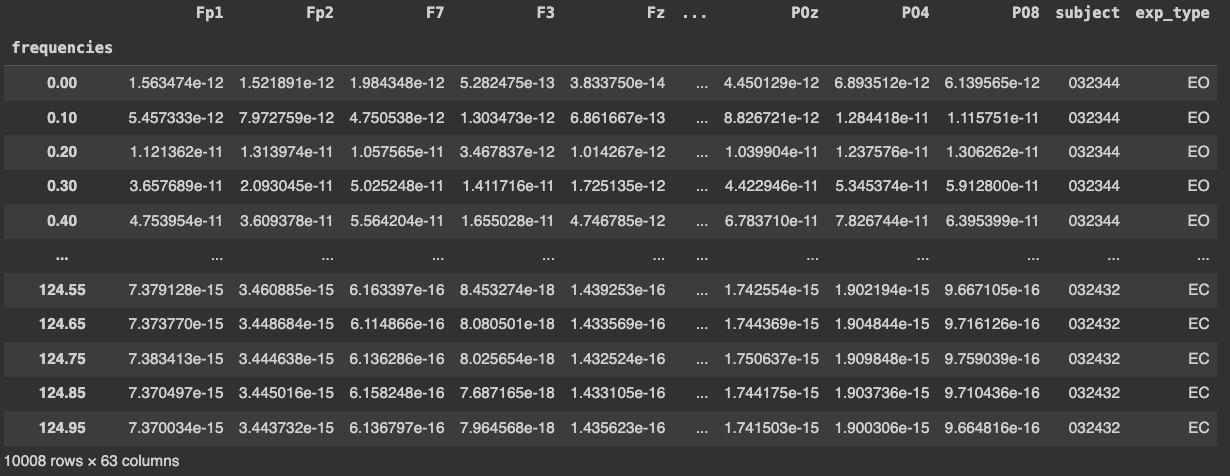

In [ ]:
##### insert your code #####

############################

Use the following cell to display your data frame.

In [ ]:
import pandas as pd

pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
psds_df

The DataFrame you obtained is in **wide format**. This format is useful for some operations like displaying the data as a **heatmap**. However, there are repetitions across subjects and experiment types. You would like to show as a heatmap the average (across subject) difference in PSD between the EC and the EO conditions (i.e., mean(EC - EO)). Create a new data frame `mean_constrast_df` containing this contrast. This dataframe should have dimensions `(int((psds_df).shape[0]/8), (psds_df).shape[1]-2)`.

Excluding imports and empty lines, a solution can be provided in ~3 lines of code.

In [ ]:
##### insert your code #####

############################

Use the following cell to display you heatmap.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.heatmap(mean_constrast_df.T, ax=ax)

**On Blackboard, answer questions 1 to 3. You have unlimited trials.**

**Question 1**: If you average across channels, at what frequency is the difference in power between eye-open (EO) and eye-close (EC) condition peaking?

In [ ]:
##### insert your code #####


############################

**Question 2**: At what channel is power peaking at the frequency determined in the previous question?

In [ ]:
##### insert your code #####


############################

Create a dictionary `ch_peaks` which has as keys the name of the channels and as values the power at the frequency identified in **Question 1**.

In [ ]:
##### insert your code #####

############################

Run the cell below to see a `topomap` of this the EEG power across the scalp at this frequency.

In [ ]:
from csce590 import plot_values_topomap

micro = 1e-6
fig, ax = plt.subplots(1, 1)
plot_values_topomap(value_dict={k:v/micro for k, v in ch_peaks.items()},
                    montage=mne.channels.make_standard_montage('standard_1020'),
                    axes=ax,
                    vmin=np.min(np.array(list(ch_peaks.values()))/micro),
                    vmax=np.max(np.array(list(ch_peaks.values()))/micro));

The peak in EEG power you can see here for activity in the alpha band (i.e., 8-12 Hz) is what is known as the alpha rhythm. It is visible when we are at rest, and increases in amplitude when we close our eyes. It has a maximal amplitude in the visual coxtex, which is located in the occipital lobe (i.e., at the back of the head).

Let's now add some demographic information to our analysis.

In [ ]:
import io
import requests

url = "https://fcp-indi.s3.amazonaws.com/data/Projects/INDI/MPI-LEMON/MRI_MPILMBB_LEMON/Participants_LEMON.csv"
s = requests.get(url).content
demo_df = pd.read_csv(io.StringIO(s.decode('utf-8')), index_col=0)
demo_df.columns = ["gender", "age"]
gender_dic = {1: "woman", 2: "man"}


In [ ]:
demo_df.head()

In [ ]:
demo_df["gender"] = list(map(gender_dic.get, demo_df.gender))
demo_df.head()

Merge `demo_df` with `psds_df` to add gender and age to our dataset. Save the resulting DataFrame in a `psds_demo_df` variable.

A solution can be provided in 2 lines of code.

In [ ]:
##### insert your code #####


############################

**Question 3**: Compute mean(EC - EO) (as previously) for men and women for the frequency identified in Question 1 and the channel identified in Question 2. What is the value of log10(abs(`men - women`)) for these values, rounded to two decimals?

The code to answer this question can be written in ~4 lines of code.

In [ ]:
##### insert your code #####


############################

# Submission

Please submit a .ipynb file containing your answers in Blackboard. A simple way to generate such a .ipynb file from a Colab Notebook is to click File --> Download --> Download .ipynb. This .ipynb file will need to be added as an attachment to your submission. The deadline to submit your lab is specified on Blackboard. Late submissions are penalized 20% per day.